# Import Libraries

In [33]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load the preprocessed data


In [14]:
data_dir = Path("../../data/processed")  
files = {
    "DF": data_dir / "players_data_DF.parquet",
    "FW": data_dir / "players_data_FW.parquet",
    "GK": data_dir / "players_data_GK.parquet",
    "MF": data_dir / "players_data_MF.parquet",
}

def load_clean(path):
    table = pq.read_table(path)
    table = table.replace_schema_metadata(None)
    return table.to_pandas()

df_fw = load_clean(files["FW"])
df_df = load_clean(files["DF"])
df_gk = load_clean(files["GK"])
df_mf = load_clean(files["MF"])



# Cluster Forwards 

In [44]:
print("FW shape:", df_fw.shape)
df_fw.head()
df_fw.info()
df_fw.describe()
df_fw.select_dtypes(include="object").columns


drop_cols = ["Rk", "__index_level_0__"] + ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'foot']
fw_features = df_fw.drop(columns=drop_cols, errors="ignore")

print("Numeric dataset shape:", fw_features.shape)
fw_features.head()

imputer = SimpleImputer(strategy="mean")
fw_imputed = imputer.fit_transform(fw_features)


scaler = StandardScaler()
fw_scaled = scaler.fit_transform(fw_imputed)


pca = PCA(n_components=2, random_state=42)
fw_pca = pca.fit_transform(fw_scaled)

kmeans = KMeans(n_clusters=6, random_state=42)
fw_clusters = kmeans.fit_predict(fw_pca)

df_fw["cluster"] = fw_clusters



FW shape: (464, 128)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464 entries, 0 to 463
Columns: 128 entries, Rk to cluster
dtypes: float64(73), int32(1), int64(48), object(6)
memory usage: 462.3+ KB
Numeric dataset shape: (464, 120)


### Plot and List

Players in cluster 0: 143


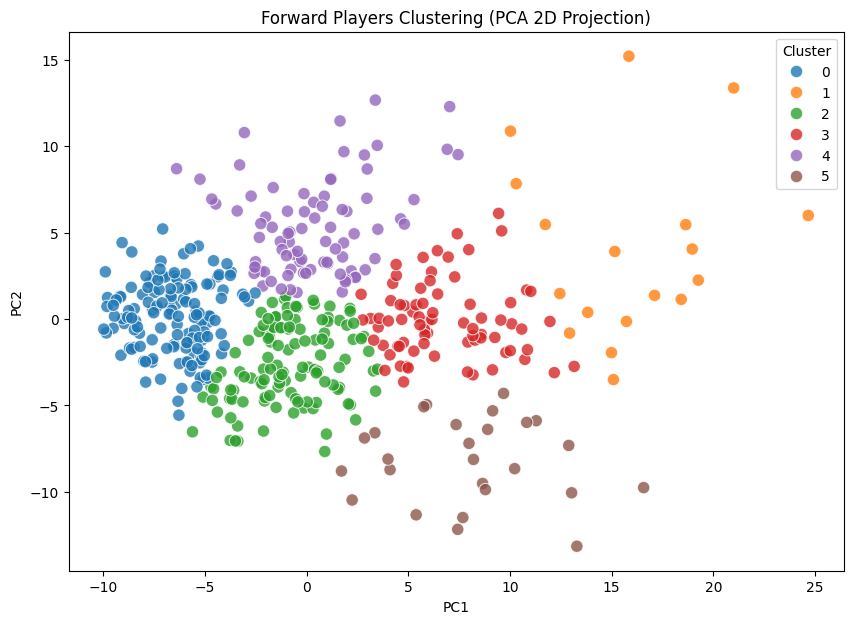

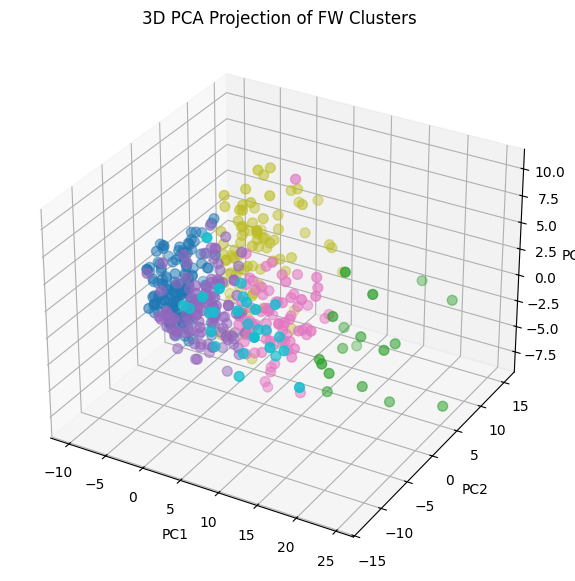

In [ ]:



plt.figure(figsize=(10,7))
sns.scatterplot(
    x=fw_pca[:,0], 
    y=fw_pca[:,1], 
    hue=df_fw["cluster"],       # color by cluster
    palette="tab10", 
    s=80,
    alpha=0.8
)
plt.title("Forward Players Clustering (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()




pca_3d = PCA(n_components=3)
fw_pca_3d = pca_3d.fit_transform(fw_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(fw_pca_3d[:,0], fw_pca_3d[:,1], fw_pca_3d[:,2], c=df_fw["cluster"], cmap="tab10", s=50)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Projection of FW Clusters")
plt.show()

In [50]:
df_fw.head()

cluster_0_players = df_fw[df_fw["cluster"] == 1][["Player", "Squad", "Pos", "cluster"]]
print(f"Players in cluster 0: {len(cluster_0_players)}")
cluster_0_players

Players in cluster 0: 18


,Player,Squad,Pos,cluster
11,Maghnes Akliouche,Monaco,"FW,MF",1
35,Alex Baena,Villarreal,"MF,FW",1
39,Bradley Barcola,Paris S-G,FW,1
80,Rayan Cherki,Lyon,"FW,MF",1
90,Matheus Cunha,Wolves,"MF,FW",1
103,Ousmane Dembélé,Paris S-G,FW,1
170,Mason Greenwood,Marseille,"FW,MF",1
205,Alex Iwobi,Fulham,"FW,MF",1
216,Vinicius Júnior,Real Madrid,FW,1
276,Kylian Mbappé,Real Madrid,FW,1
